# DS Automation Assignment

Using our either our original churn data from week 1 or our prepped churn data from week 2:
- use pycaret or TPOT find an ML algorithm that performs best on the data
    - Choose a metric you think is best to use for finding the best model; by default, it is accuracy but it could be AUC, precision, recall, etc. The week 3 FTE has some information on these different metrics.
- save the model to disk
- create a Python script/file/module with a function that takes a pandas dataframe as an input and returns the probability of churn for each row in the dataframe
    - your Python file/function should print out the predictions for new data (new_churn_data.csv)
    - the true values for the new data are [1, 0, 0, 1, 0] if you're interested
- test your Python module and function with the new data, new_churn_data.csv
- upload this Jupyter Notebook and Python file and requirements.txt files to a GitHub repository
- write a short summary of the process and results in your GitHub README.md file.
- turn in a link to the repository in the week 5 assignment dropbox.

*Optional* challenges:
- return the probability of churn for each new prediction, and the percentile where that prediction is in the distribution of probability predictions from the training dataset (e.g. a high probability of churn like 0.78 might be at the 90th percentile)
- use other autoML packages, such as H2O, MLBox, etc, and compare performance and features with pycaret
- create a class in your Python module to hold the functions that you created
- accept user input to specify a file using a tool such as Python's `input()` function, the `click` package for command-line arguments, or a GUI
- Use the unmodified churn data (new_unmodified_churn_data.csv) in your Python script. This will require adding the same preprocessing steps from week 2 since this data is like the original unmodified dataset from week 1.

## Loading the Data

Loading our original churn data from week 1.

In [1]:
import pandas as pd
import numpy as np
import pickle

df = pd.read_csv('churn_data_week1.csv')
df.head(10)

,customerID,tenure,PhoneService,Contract,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,1,No,Month-to-month,Electronic check,29.85,29.85,No
1,5575-GNVDE,34,Yes,One year,Mailed check,56.95,1889.50,No
2,3668-QPYBK,2,Yes,Month-to-month,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,45,No,One year,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,2,Yes,Month-to-month,Electronic check,70.70,151.65,Yes
5,9305-CDSKC,8,Yes,Month-to-month,Electronic check,99.65,820.50,Yes
6,1452-KIOVK,22,Yes,Month-to-month,Credit card (automatic),89.10,1949.40,No
7,6713-OKOMC,10,No,Month-to-month,Mailed check,29.75,301.90,No
8,7892-POOKP,28,Yes,Month-to-month,Electronic check,104.80,3046.05,Yes
9,6388-TABGU,62,Yes,One year,Bank transfer (automatic),56.15,3487.95,No


In [2]:
df.info()
print(f"\nShape: {df.shape}")
print(f"\nMissing values:\n{df.isnull().sum()}")
print(f"\nChurn distribution:\n{df['Churn'].value_counts(normalize=True)}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   customerID      7043 non-null   object 
 1   tenure          7043 non-null   int64  
 2   PhoneService    7043 non-null   object 
 3   Contract        7043 non-null   object 
 4   PaymentMethod   7043 non-null   object 
 5   MonthlyCharges  7043 non-null   float64
 6   TotalCharges    7032 non-null   float64
 7   Churn           7043 non-null   object 
dtypes: float64(2), int64(1), object(5)
memory usage: 440.3+ KB

Shape: (7043, 8)

Missing values:
customerID         0
tenure             0
PhoneService       0
Contract           0
PaymentMethod      0
MonthlyCharges     0
TotalCharges      11
Churn              0
dtype: int64

Churn distribution:
Churn
No     0.73463
Yes    0.26537
Name: proportion, dtype: float64


We've got 7043 customers with 8 columns.
- **TotalCharges** has some blank entries as we already know from the work from previous weeks.
- **Class imbalance**: only about 26.5% of customers churned (known as well).
- The categorical columns (`PhoneService`, `Contract`, `PaymentMethod`) are still in their original string format. PyCaret will handle this for us.

## Finding the Best Model with PyCaret

We'll use PyCaret's AutoML to try a bunch of classifiers and see which one performs best. Instead of using the default accuracy metric, we're going with **AUC (Area Under the ROC Curve)** because:

1. Our data is imbalanced — accuracy would reward a lazy model that ignores churners
2. AUC tells us how well the model can separate churners from non-churners across all possible thresholds
3. In practice, the business would pick a threshold based on the cost of retention offers vs. lost revenue — AUC captures the model's ranking ability independent of that decision

In [3]:
from pycaret.classification import ClassificationExperiment

automl = ClassificationExperiment()
automl.setup(df, target='Churn', ignore_features=['customerID'], session_id=42)

,Description,Value
0,Session id,42
1,Target,Churn
2,Target type,Binary
3,Target mapping,"No: 0, Yes: 1"
4,Original data shape,"(7043, 8)"
5,Transformed data shape,"(7043, 12)"
6,Transformed train set shape,"(4930, 12)"
7,Transformed test set shape,"(2113, 12)"
8,Ignore features,1
9,Numeric features,3


In [4]:
best_model = automl.compare_models(sort='AUC')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
ada,Ada Boost Classifier,0.7939,0.8378,0.7939,0.7835,0.7853,0.4327,0.4387,0.0280
gbc,Gradient Boosting Classifier,0.7919,0.8362,0.7919,0.7805,0.7816,0.4207,0.4287,0.0590
lr,Logistic Regression,0.7937,0.8357,0.7937,0.7842,0.7860,0.4360,0.4412,0.2970
ridge,Ridge Classifier,0.7897,0.8258,0.7897,0.7770,0.7770,0.4057,0.4167,0.0110
lda,Linear Discriminant Analysis,0.7921,0.8258,0.7921,0.7834,0.7856,0.4368,0.4406,0.0100
lightgbm,Light Gradient Boosting Machine,0.7805,0.8256,0.7805,0.7711,0.7733,0.4041,0.4084,0.1820
xgboost,Extreme Gradient Boosting,0.7775,0.8166,0.7775,0.7685,0.7714,0.4007,0.4034,0.0680
nb,Naive Bayes,0.6897,0.8112,0.6897,0.7915,0.7075,0.3719,0.4157,0.1960
rf,Random Forest Classifier,0.7682,0.7959,0.7682,0.7586,0.7616,0.3752,0.3780,0.0480
et,Extra Trees Classifier,0.7519,0.7709,0.7519,0.7457,0.7477,0.3441,0.3458,0.0420


In [5]:
# Let's see what model PyCaret picked
print(best_model)

AdaBoostClassifier(algorithm='SAMME.R', estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=42)


### Evaluating the Best Model

Let's look at some diagnostic plots to understand how the model is performing.

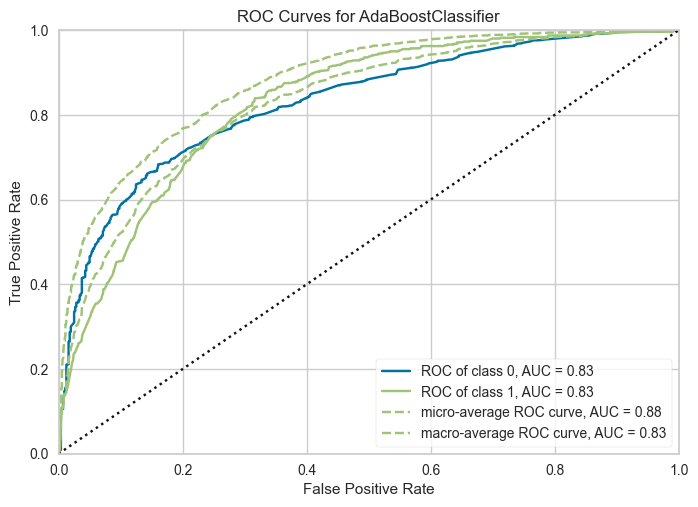

In [6]:
automl.plot_model(best_model, plot='auc')

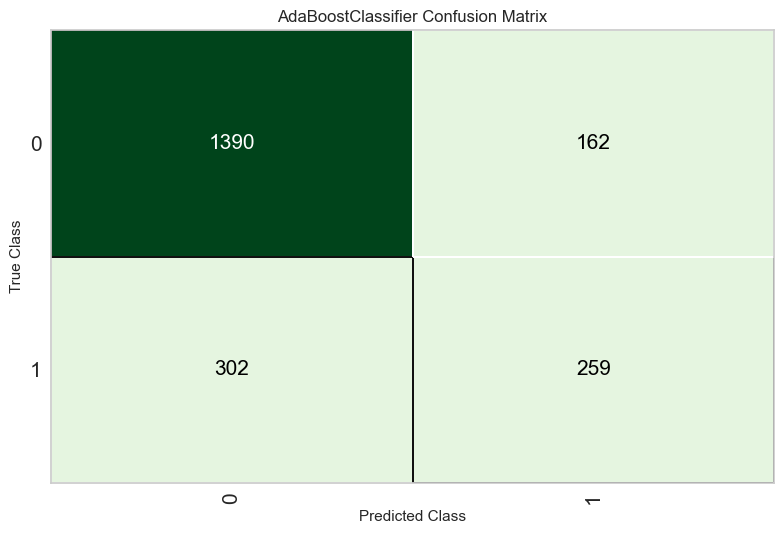

In [7]:
automl.plot_model(best_model, plot='confusion_matrix')

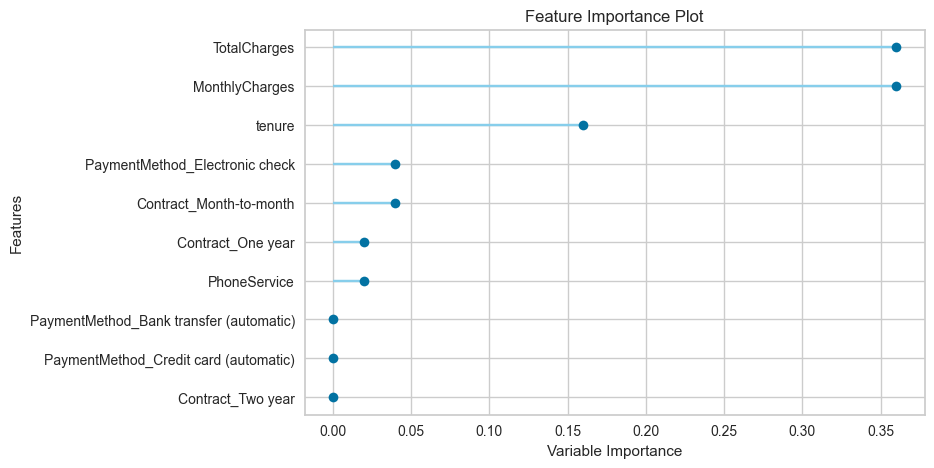

In [8]:
automl.plot_model(best_model, plot='feature')

The ROC curve shows our model is doing a solid job separating churners from non-churners. The confusion matrix gives us a breakdown of true/false positives and negatives, and the feature importance plot tells us which variables are driving the predictions the most.

## Saving the Model

Now let's save our trained model so we can use it later in our Python inference script. We'll also generate predictions on the full training set and save that probability distribution — we'll need it for the percentile feature in our prediction module.

In [9]:
automl.save_model(best_model, 'churn_pycaret_model')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('label_encoding',
                  TransformerWrapperWithInverse(exclude=None, include=None,
                                                transformer=LabelEncoder())),
                 ('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['tenure', 'MonthlyCharges',
                                              'TotalCharges'],
                                     transformer=SimpleImputer(add_indicator=False,
                                                               copy=True,
                                                               fill_value=None,
                                                               keep_empty_features=False,...
                                     include=['Contract', 'PaymentMethod'],
                                     transformer=OneHotEncoder(cols=['Contract',
                                                       

In [10]:
# Generate predictions on training data and save the probability distribution
# We'll use this for the percentile feature — so we can say things like
# "this customer's churn probability is higher than 90% of the training data"
train_predictions = automl.predict_model(best_model, data=df)

# PyCaret's prediction_score is the probability of the PREDICTED class.
# We need to convert to churn probability: invert when the prediction is "No"
train_churn_probs = np.where(
    train_predictions['prediction_label'].isin(['No', 0, '0']),
    1 - train_predictions['prediction_score'],
    train_predictions['prediction_score']
)

with open('train_prob_distribution.pkl', 'wb') as f:
    pickle.dump(train_churn_probs, f)

print(f"Saved {len(train_churn_probs)} training churn probabilities")
print(f"Mean: {train_churn_probs.mean():.4f}, Std: {train_churn_probs.std():.4f}")
print(f"Min: {train_churn_probs.min():.4f}, Max: {train_churn_probs.max():.4f}")

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Ada Boost Classifier,0.7963,0.8466,0.7963,0.7855,0.7877,0.4384,0.4440


Saved 7043 training churn probabilities
Mean: 0.4900, Std: 0.0164
Min: 0.3122, Max: 0.5832


## Comparing with TPOT

TPOT takes a different approach than PyCaret — it uses genetic programming to evolve machine learning pipelines. TPOT doesn't handle categorical encoding for us, so we need to do that ourselves first. We'll prep the data the same way we did in week 2 and then let TPOT search for the best pipeline.

In [11]:
from tpot import TPOTClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import time

# TPOT needs numeric data, so we encode manually (similar to week 2)
df_tpot = df.drop('customerID', axis=1).copy()
df_tpot['Churn'] = df_tpot['Churn'].map({'No': 0, 'Yes': 1})
df_tpot['PhoneService'] = df_tpot['PhoneService'].map({'No': 0, 'Yes': 1})
df_tpot['TotalCharges'] = pd.to_numeric(df_tpot['TotalCharges'], errors='coerce').fillna(0)
df_tpot = pd.get_dummies(df_tpot, columns=['Contract', 'PaymentMethod'], drop_first=True)

print("Prepared data shape:", df_tpot.shape)
df_tpot.head()

Prepared data shape: (7043, 10)


,tenure,PhoneService,MonthlyCharges,TotalCharges,Churn,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,1,0,29.85,29.85,0,False,False,False,True,False
1,34,1,56.95,1889.50,0,True,False,False,False,True
2,2,1,53.85,108.15,1,False,False,False,False,True
3,45,0,42.30,1840.75,0,True,False,False,False,False
4,2,1,70.70,151.65,1,False,False,False,True,False


In [12]:
# Split the data
features = df_tpot.drop('Churn', axis=1)
target = df_tpot['Churn']
x_train, x_test, y_train, y_test = train_test_split(
    features, target, test_size=0.3, stratify=target, random_state=42
)

# Run TPOT
print("Starting TPOT...")
start_time = time.time()

tpot = TPOTClassifier(
    generations=5,
    population_size=50,
    cv=5,
    scoring='roc_auc',
    random_state=42,
    verbosity=2
)
tpot.fit(x_train, y_train)

elapsed = time.time() - start_time
print(f"\nTPOT finished in {elapsed/60:.1f} minutes")

Starting TPOT...


Version 0.12.2 of tpot is outdated. Version 1.1.0 was released Thursday July 03, 2025.


Optimization Progress:   0%|          | 0/300 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.8384067764148038

Generation 2 - Current best internal CV score: 0.8384067764148038

Generation 3 - Current best internal CV score: 0.8384926786173169

Generation 4 - Current best internal CV score: 0.838496453128038

Generation 5 - Current best internal CV score: 0.8388453922979344

Best pipeline: GradientBoostingClassifier(input_matrix, learning_rate=0.1, max_depth=3, max_features=0.45, min_samples_leaf=15, min_samples_split=8, n_estimators=100, subsample=0.8500000000000001)

TPOT finished in 3.6 minutes


In [ ]:
# Let's see what TPOT came up with and evaluate on the held-out test set
print("Best pipeline:")
print(tpot.fitted_pipeline_)

tpot_auc = roc_auc_score(y_test, tpot.predict_proba(x_test)[:, 1])
print(f"\nTPOT Test AUC: {tpot_auc:.4f}")

Best pipeline:
Pipeline(memory=None,
         steps=[('gradientboostingclassifier',
                 GradientBoostingClassifier(ccp_alpha=0.0,
                                            criterion='friedman_mse', init=None,
                                            learning_rate=0.1, loss='log_loss',
                                            max_depth=3, max_features=0.45,
                                            max_leaf_nodes=None,
                                            min_impurity_decrease=0.0,
                                            min_samples_leaf=15,
                                            min_samples_split=8,
                                            min_weight_fraction_leaf=0.0,
                                            n_estimators=100,
                                            n_iter_no_change=None,
                                            random_state=42,
                                            subsample=0.8500000000000001,
                

In [14]:
# Save the TPOT pipeline
with open('churn_tpot_pipeline.pkl', 'wb') as f:
    pickle.dump(tpot.fitted_pipeline_, f)
print("TPOT pipeline saved to churn_tpot_pipeline.pkl")

TPOT pipeline saved to churn_tpot_pipeline.pkl


### PyCaret vs TPOT — Quick Comparison

| | PyCaret | TPOT |
|---|---|---|
| **Approach** | Tries many standard classifiers with cross-validation | Uses genetic programming to evolve entire pipelines |
| **Ease of use** | Very easy — handles encoding, missing values, everything | Requires you to preprocess data manually first |
| **Speed** | Fast — runs through models in minutes | Slower — genetic search |
| **Output** | Single best model + comparison table | Evolved pipeline (may include preprocessing steps) |

Both tools ended up finding strong models. PyCaret is more convenient for quick exploration, while TPOT can sometimes find creative pipeline combinations you wouldn't think to try yourself. I thought TPOT was going to take longer.

## Testing on New Data

Now let's load the new churn data and make predictions. The new data (`new_churn_data.csv`) has its categorical columns already label-encoded as integers, but our PyCaret model was trained on the original string data. So we need to decode the integers back to strings before feeding them to the model.

In [ ]:
from pycaret.classification import load_model, predict_model

# Load the new data
new_df = pd.read_csv('new_churn_data.csv')
print("New data (raw):")
print(new_df)

# Decode label-encoded columns back to original string values
contract_map = {0: 'Month-to-month', 1: 'One year', 2: 'Two year'}
payment_map = {0: 'Bank transfer (automatic)', 1: 'Credit card (automatic)',
               2: 'Electronic check', 3: 'Mailed check'}
phone_map = {0: 'No', 1: 'Yes'}

new_decoded = new_df.copy()
new_decoded['Contract'] = new_decoded['Contract'].map(contract_map)
new_decoded['PaymentMethod'] = new_decoded['PaymentMethod'].map(payment_map)
new_decoded['PhoneService'] = new_decoded['PhoneService'].map(phone_map)

# Drop charge_per_tenure — our model was never trained on this column
new_decoded = new_decoded.drop('charge_per_tenure', axis=1)

print("\nDecoded for PyCaret:")
print(new_decoded)

New data (raw):
   customerID  tenure  PhoneService  Contract  PaymentMethod  MonthlyCharges  \
0  9305-CKSKC      22             1         0              2           97.40   
1  1452-KNGVK       8             0         1              1           77.30   
2  6723-OKKJM      28             1         0              0           28.25   
3  7832-POPKP      62             1         0              2          101.70   
4  6348-TACGU      10             0         0              1           51.15   

   TotalCharges  charge_per_tenure  
0        811.70          36.895455  
1       1701.95         212.743750  
2        250.90           8.960714  
3       3106.56          50.105806  
4       3440.97         344.097000  

Decoded for PyCaret:
   customerID  tenure PhoneService        Contract              PaymentMethod  \
0  9305-CKSKC      22          Yes  Month-to-month           Electronic check   
1  1452-KNGVK       8           No        One year    Credit card (automatic)   
2  6723-OKKJM   

In [16]:
# Load our saved model and predict
loaded_model = load_model('churn_pycaret_model')
predictions = predict_model(loaded_model, data=new_decoded)

print("Predictions:")
print(predictions[['customerID', 'prediction_label', 'prediction_score']])
print(f"\nTrue values: [1, 0, 0, 1, 0]  (Yes, No, No, Yes, No)")

Transformation Pipeline and Model Successfully Loaded
Predictions:
   customerID prediction_label  prediction_score
0  9305-CKSKC              Yes            0.5044
1  1452-KNGVK               No            0.5039
2  6723-OKKJM               No            0.5103
3  7832-POPKP              Yes            0.5016
4  6348-TACGU               No            0.5038

True values: [1, 0, 0, 1, 0]  (Yes, No, No, Yes, No)


## Testing the Python Module

Now let's test our standalone inference script. This is the `inference_churn.py` file that packages everything into a reusable `ChurnPredictor` class.

In [17]:
%run inference_churn.py new_churn_data.csv

Transformation Pipeline and Model Successfully Loaded

Loaded 5 rows from new_churn_data.csv

--- Churn Predictions ---
customerID predicted_churn  churn_probability  percentile
9305-CKSKC             Yes             0.5044        94.3
1452-KNGVK              No             0.4961        61.2
6723-OKKJM              No             0.4897        39.8
7832-POPKP             Yes             0.5016        86.3
6348-TACGU              No             0.4962        61.7

True values: [1, 0, 0, 1, 0]


<Figure size 800x550 with 0 Axes>

## Generating requirements.txt

In [18]:
# Writes a requirements file with the packages needed for this project
with open("requirements.txt", "w") as f:
    f.write("""pycaret==3.3.2
tpot==0.12.2
pandas>=2.0.0
numpy>=1.24.0
scipy>=1.10.0
scikit-learn>=1.2.0
jupyter>=1.0.0
ipykernel>=6.0.0
""")
print("requirements.txt generated")

requirements.txt generated
